<a href="https://colab.research.google.com/github/pumpzcc/EvolutionaryDeepLearning/blob/main/EDL_4_4_EvoLisa_ES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install DEAP
!pip install deap --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 4.2 MB/s eta 0:00:00


In [2]:
#@title Imports
import random
import numpy as np

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

import os
import cv2
import urllib.request
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
#@title Image Helpers
def load_target_image(image_url, color=True, size=None):
  image_path = "target_image"
  urllib.request.urlretrieve(image_url,image_path)
  if color:
      target = cv2.imread(image_path, cv2.IMREAD_COLOR)
      # Switch from bgr to rgb
      target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
  else:
      target = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

  if size:
      # Only resizes image if it is needed!
      target = cv2.resize(src=target, dsize=size, interpolation=cv2.INTER_AREA)
  return target

def show_image(img_arr):
  plt.figure(figsize=(10,10))
  plt.axis("off")
  plt.imshow(img_arr/255)
  plt.show()

def show_results(history, img_arr, org):
  plt.figure(figsize=(10,10))
  plt.tight_layout()

  plt.subplot(221)
  plt.axis("off")
  plt.imshow(img_arr/255)
  plt.title('best of generation')

  plt.subplot(222)
  plt.axis("off")
  plt.imshow(org/255)
  plt.title('target image')

  plt.subplot(212)
  lh = len(history)
  plt.xlim([lh-50, lh])
  plt.plot(history)
  plt.title('min fitness by generation')
  plt.show()


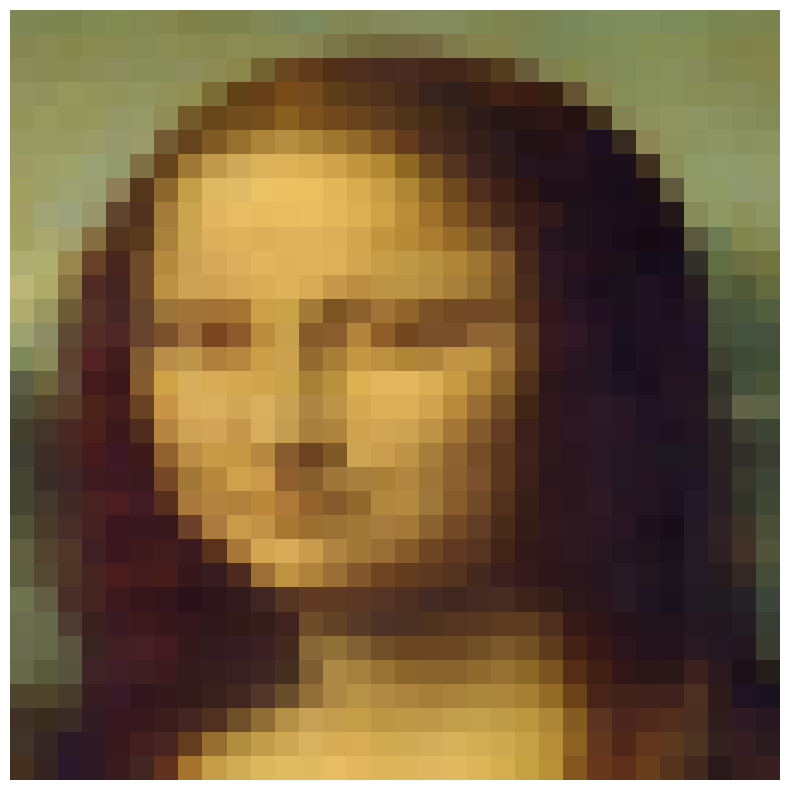

(32, 32, 3)


In [4]:
#@title Default title text { run: "auto" }
polygons = 255 #@param {type:"slider", min:10, max:1000, step:1}
size = 32 #@param {type:"slider", min:16, max:1000, step:2}
target_image = "Mona Lisa" #@param ["Mona Lisa", "Stop Sign", "Landscape", "Celebrity", "Art", "Abstract"]
report_every_gen = 10 #@param {type:"slider", min:1, max:100, step:1}
number_generations = 10000 #@param {type:"slider", min:100, max:10000, step:10}


POLYGONS = polygons
SIZE = (size, size)

target_urls = { "Mona Lisa" : 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYWFRgWFhYZGRgaHBodHBwaGhwaHBoeGhofGRwaGhocIS4lHh4rHx8aJjgmKy8xNTU1GiQ7QDszPy40NTEBDAwMEA8QHhISHjQrJCs0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NP/AABEIAP4AxgMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAAEBQIDBgEAB//EADsQAAECAwUHAwMDAgUFAQAAAAEAAgMRIQQxQVHwBRJhcYGRsaHB0SLh8QYTMkJSFGJyksIVI4Ki0jP/xAAZAQADAQEBAAAAAAAAAAAAAAABAgMABAX/xAAiEQADAQADAQEAAgMBAAAAAAAAAQIRAxIhMUEEURMiMmH/2gAMAwEAAhEDEQA/AOFmrlEhWNdMyXHBec2HDjQp7q7guBDdNhGWCg8K5tF4hZ6FFG7cusarGjypuatpsKi1dDFPdUHxGtq4gcymVA6tnntXGtQkbasNv9YPKvhDP25Dzd/tK3oymhuulJv+vMnc7srGbchE/wApcwQm9N0YzcoFVMtjHXOB5FW74SNg6siQugTXpr0kyFZNrFIKAJUwbltFw6VGRUqrxQ7BwreFGVOPypPCgUNCkemurpvXkNYcLnM8Z8Fzc1NXuNFJjVmEo3V0K0jVFxgWTMUkKRHZWFqiSBfJbcMkQY2qGtm0GMvPz0Qm1Npbsw2rssuP2Wfc1z3TcZkoffS0xv0Mj7be+jfpHc90E9jnVLieatgwBPuibQyQkj2SeIupSQnPHVVEvMr9TRb4fBUuhq00hGUGJTr7KDyJ3q18PXRDRGKqxittE2gioMuSJh7RiM/qJHGoS7fIxU2WgYhapAmn9NLY/wBQtueCOIMwnsKM1wm0gjgvnj2g3S4qVi2g+C6bTMYg1H5U3x6vBahH0ZoUkq2RtdkUUMnSq03jlmE3AUfV4yVTh1rV4ld3blxzFhSt3PXJRaZ3K0sXHMW9YSoheUjqS8hgdDGhdeV0Xa4rpQwxE8F5TDV4tqmlGZBwkEj2xtHd+ht6abTtYYwnEzksa6bnEm8rZpXjn9LGgkmd/fHNWtZRFWXZr3YS5802s+wsz2UquUdCQms0Iz1ku2ms1qWbKDRTVPz2XI+ymG8KX+RboxjHtVD6LVxNjt4oGNscYHvJVnlkDRmoomhntTa07Pc3ilsRhC6opV8ZOpwDeAh3NCLexDkSXRJJoq3yMl0mai+9RBlXumwCZKFFcxwc0yIxX0DYW1mxmV/mLx7jgvn0R01bYLW6E8PabpfhLycXZb+gf9H1ZgnyUw1A7GtzYrA9pvFRkckZvEri90Slh4tVblc0KJhIilC8r9z5XljBH7clZu4qMlNoSL0ZnHUCpe6SuLike39oCGw1qaD7Kn5hpnsxNtu1l791twpzzKO2PYwBM1PdIdnfW+t2r1vtmwQAAAo89dVh2QkEWSA403QOdckwZZzicOF8p+/or4DAJe6sby4cLvea5NHKTBlnh5kouswrf3OXyjHS8/K8fX3+KKejCmJZb5cM+SCiWU50wxTt7KDp7IOM05I6YzNvsplVZ+1WRbS1wc0htkOq6OK8YrRk7RDIwkgntTu1w0risXpcd6iNSL30USTcrYrEOQV0y9JNYSe1ROvHwvErjkyFY6/TG1DCibpP0Ov4ZFfRmO3hNfIGOqCvpH6Xt37kIV+pv0n2PZcnNGPsgV6h4RJeevZrgNKqK/omdC8okz0F5bAhLb9cVMBcYzwff5VjgkmsHa0FtEQNaSbhrusH+oXOLg52ZkMhktNtW2fycT9LTQDEyvWM2naC9wOGSrDbrwrE4tGP6caCeq3dhpJYv9PwrittZW0C5P5D2mdE/BvC+ArWvu5t9kK40pqk1JxprAyr1kVyscvY/wAf/PypE66oU07eDP2U3On6oYYk92utELFerHHXUoKM72K2GB7S+aS2uHNNXtuQcdk08+GM7aIaT2mHKa1NpgJXabIu3isnSM09qpikI23Q90pc4TXoR76QrzwgWqJPspkKBCqiZyd4Wg/RlqLY25OjxLq2rf8AkOoWcKJsMYsex4Mt0g9jP5S3PaWgH10RAAScQqt+c5ZJaLXvNnOhAlLJX2aIZTJrOfLgvPpYtEX3BjCd7LyDMXiZcF5YxoCySGt8STHS5d6I+VDy+El2zF3Q2fE9gpb6VS9Mjt2NINbx16ArP2l9wTTbv82u4eJ/KVRa3ZLs4pSSLt+Gy/TzBuC65aizAyuFOIzWa/TQmxvALUQokhP4Xncv/bKr4FMnMU4f05K6G67WE/jsgf8AFCd6IhRQRTUyosYIPzwoarktU4qDXU7KNoihomdXJTEnuprnJDuE8POaBtO1QKDWCpZtCeKbqzBf7Wun5VD2Ln+KGari2huaKQpVGhBK7YwSwRke1DRS21R1WJembM1tFtSlQomtvN6VPAK9Xh+HPf0pLqg6pVRlMHNdLfdcYK9FfCTZDdXQaKxzVDdoiDDb7KjThMJ/tHe5FWePeDea3/CT7Fif9gcCfN3qUUyN9Y517LiufWJ8Y0FplcO9T5ovKhtQD9/K8pdUHTZxIhCzm2Yv1DOR9vVOYjwbuqQbbhzAdO6fYyCEyhk9ZnLeN4EXy0eX3QH7Uh1KujRTMjjhkSqREoRxmuqU14dOeemi2LbNxgoNZJtD2i+JRjSZdB3SawbPc+EHDtPVEw2fs2I6hJa0f245zIXHyKdbKSFPgxsd3lvK6wW5zHbrsc0gt+zYgiEMDr6H6jTmmGz7NEIk+chORN4+yjUz1+jmtc83pNtm2EAhOLGwmGCb9e6yu2Jl4xCjxTtAYs/xDnOomtnsL5Tc8NHFV7OsBMiJAk44JvadizYZkueRSshNWu5TxGSFNpgEfxisJ5j5Sy0Wx7LxTNc/6Q+Z+k8pG/wrDs2JKRPQ1VJ6L69A9A3W8q5jy4TR1n/TxNXEdEfF2e1jUXc/JBj/AEyFuYZXJQ9i0e0mLOxRVdnA9RKyp4M7tG5Vz1zRDxrpNDnR4YrqXpGvDpcV5uK8wLwCwB1sZ5MNzRgQcr5JjZ3gTzSrYrqu5A+v4TT9w8lC1/s0Sr6Ew4hAoV5COmfyvJOqFNXYLWHb54j4S/bMbfG4LganM0p0QVhjloef8pP5UXvnLG+dAeZJGM/Kk5yi0IQl0jxQwfWuPyr7YCHnohC6q6Ejqb1H0j9OwJwWXVbUSThlle3+MsUp/S8f/tM6LSQYkxThnruvG5KfdorngltLYzjKUuqus9kIb9RTktqDzxGBzVEUC7XHFI6fwJ2CZMlz1rJZjaDJvK1JhyaeQv7JHHZM3Zow2mBkNnwTUDL2TBzXi4TULG2WuH2TsAUpjlPhiUtU9ChBEgxT/QZqEPZr730Wl3hLPlXGWHlDRDr1z5rdmjYL2wt29Lbe8VRtpiJJb41CnhNvTMzm1Yl4WeiGqb7TiTKSurhx7L1+BYjmtngZ+nPL3HdUlXTxHD0wmoPZ5+ZU5zXUiLINNFNzcVx/8rsvWslYyms6LMyDNkRd15F82+CEz/ekc0l2d/8AqBz+VoRCpO+lwn8KN/8AWk6Ih2MpLytM8J9pjuvKWi4VOiya4SvEvYKES0kY4S9MDl8qiKXeszhh91Q9+Yzu6TR66Xg5EnM41819kPEZSdOKsc2p4SPVDPcZppXp0PxG3/SEebACtrBAAFZXYL5t+lI8jJfQLLG3gJ6ovL/kTlsrL/1Qwc++WrvSapmJ56muOiSQ8J83yUQ4GxXfR0+yR2ihnrV6dWl4DenDL4WejRWky3h0uTSKMLG8TTGG8a6YpFs2K3f3Z3zl2Tndlhq/4S0vRkEOf9OqUQ0WJReiOEvvwQFoi0QUm0DtkRIrZER1tjcUltT5jourigWmJLa+ZQIdI9vKKtNUKT6fJK9LjWI56+nmGUp0x5kVmOclw58vAn6kqVxAOrvkrjjMUuGvKsTK3urxmDwoJrzDQjh4r5XRUz4yp/4gdyZKAvE7q9rkRQmyPAiMc4TAdIyxmCFrmxYR/paOYPahqsa1tOII/Kaw4po6Zw4c78VG50DHzYsMn+AuzdwyevJQx+YddkD5XlPqhPSmMBInhx+6qLBKv+XxJFxGzaZXDul7hLoU69KwVuiSlxHv+VCUq5j7K17ZnkP+Sg6HKaZYjo9aDdiRC18lvbBaaL5zZ37rwePmq3NiE2iS4f5U+6Uh+Ghgv3l21WEkh7HSc3DBwyS+DF3alNLPamuE94d157TT0oZnau1n/wASC0i8FZ0xnl1CVtds2IRDOks0lbYmtK6uK5U/BaTOfp9rv3A5y2L4wks7CjNYMF4W/eMgZqdp09AvBxEjJZan3q5k5VQtpallBYstJJSm0zkm1ooldsK64FYljoQn2RVoQjjrmu6Phz0eZxOfio7zXX4DPMcqnnPV66TXv609yuPAyw9T+FVCMi2V5yr3BPuq3i7H8q15qKYzp1+yrccta+UUK0Esq8iePuB5REA0BpR3LLXVCw3VnwB8e1UwskpSv+o6op14B/CUR9BMDxmMuC6r3Py8ryQTSTm6vQkRn050n2Mtc0zjfwNMEC84DIDUkiZWAWUz08kHzNVRIl4nlqSm98uXXj8lDvInrHRVEvToTxE30GsCR7BbD9PWwOaATcsYW+OPOiJ2fazDdMXKfNx95DNYz6WYQeJKTNhsDZ7zgZ4FKtl7SDgKjBaBkWbRrBeVaqXhYDi7OcGybEn/AKh8JVadmOH9YTS22V5/iSEvdZX4krS2v0LYA3Z0zIuPRNbFYmMEmiuJvKrbBIqpB5Cem680QYOkAl1qePClEjSCV2m0rTPpmUWh9Urtj71dGjIK0uXXE4JTAIqHeOOpq6M5VE0PTXquuCLOjPqovFddD47KTrqalr1UHPloqiFIPlndL7+640ifBceb7tTC8w19kyECGtG8f9P/AAARtlP1GdZnHkg2GZlw8hMLOJmmdO6nbNmoLiSpd1uvNwXESWS0fYrijomBxgiRE50OAPulIaJUngm0OykCRdh/abpJTaWFpeDeCRdhTDqEqKwwC0NGspodkO7XP3RRbPr5cB7qhz5XVN3VVTeYi8pfpxgkZqDqTpcPdWMfL8qh7wZ4T1JFbpnmB1htjmOmNTW/2HtJrwM8V80c/kj9m25zHTBy91z8/ArWr6GLzxn2NjwQqLUWyWbsG32uFTrBTj7XBxXmf46TxotqCIz5+UDEigBCWjaYKV2i1OJXRPG2K2g+02oZpXGjzVReSq3ulerzGCtnX5oS0vXYkfLWpKhwJV5n+yboHdX09/sovEq6uVjmSmqXKyEZIgcp5dD8KIFwzmRO7nyr6Ljm01r8KbTOUwTjlhXXJOhGVSp9l1nLP4HuuuEpj8KLHesx2rLvLRRQrL2EbwPLsKIyzkDXFA3ES1iEQx8t3mPJKSloUzQQQ0zPgLyoa6QpTmZTphMheUcJaPt6mHokW1Yf1h393ag12TkPMvwgrewubMYVHulnxjy8ZnIrt0jn4KpeRNFWlsyOlNYSCFAprFo+PVWSOhP8K2sNTP8ACriNV7m0XJe0kUzNFTXTVzH1GuKgL1MNWbEL4Vo3ZaoJU8+qMbGd0S9jeH4y8rQ7MsgcyeRPlR5WpWspOgH7584dfCj+9SerppjEsOskLEssrkk1LC9BHxDWSqeSZauoiP2/ZdbCT9kvguNgzYeKsAIGuEvCJZCpgrGWWiDsPUWuhkmSpfCkE5dClrqgbUxab0zkWFe3r+fX8qTm1pl5CreJLoTJtESb+3DL4K43xdyFVJgvkAaeV4ZcvSfyn0nhIuqNXCSsa+o4KDzTue5UmCdDw+PCAGh1BjEi49D09l5RgQ2yr6nwvKeonhoA6gu7n4KoikSuHf4krA6l4NLgcr88kDCibxcDKhpOeKh+jiraDPrIGLZ44Ncc5oWGZX1lIjXZEWtw/ddlKX/r8oV776VMpHorpeHRPi064zrn7SPgqt5nM3UprqpufMslkB1uVZOu3wVhm/DsOHheeGKk0V1muAVU5VHI+6OkzrNc6TWm/TbphzeR9JLPtZfTkMqy9k82FNrwZUkufm9ljz9H0eyBLrTZloLwqXwaCi4VbRXDMvsgVYgd08jWcqswdBOuQ2ClkDXyimQs+GSMbZ+6vFnEtZoOzYKY8EY+0kqtsLDVy1EeDy8pXboExPG+7gjHJ6bDKx2ayVLjOms0dFbImeZQkSGu+KJ0gcUmNYHHqpMFVMQ5yKmyHJ3TWuKr2JYVvUP3JGYvRVoG6Z8kE/Kmpoy9QKWMcwrQHNFZd8KYLyXWaNu8j5EvleS9f/BMG/8AjHNc4TO7MiU6YqW/WYJwlKUq0zQsdkt4zp9x8qsRyGnlMc5yn3Uuu/Bypxq8mtB6i/z3UHXen3Xgaic5OAn6tPW9cYROusVf4PJFrZk5D2E11oNOo7GfuPVTYwyJOetcVdCh6kkbDhFrCiYUG7G8dwiLNZS4yAnoXrQ2LZrWComcaLn5OZSMpFlj2aXVPFaCz7PIAomFisssE1hwARLXquK+Z0yinBZChHJWObRF/tSmOfHuuRYZ5qDr0bAB0BVmz11imAZwUmQeA6I9jAIs8lwwr8vW/mmggyw1covZS8dPSpQ7AFceF9M5ZamlVrgHdMsAfHwVpHw6ceMr/fggLXBoWylf1pXPUlpr0JgtoQ6z+K3BAuGeJWg2lAqamgxr7XJLEZ9e7PNenw1siUioQZGWq5Lm59Q5e6IsrJvIM1KLD+uUjdT/AHKnb3BWvAa3kGokgCyk0bbRTqUOGq3H4iVesFc2TRKV+vC8iG3XgTPj8ryponUYR4hnLjhlIzQcd+Gryfco54mT19x8pfEAmRxUuNpsZrDmA5GU8b5+s/RTdfqajK7KX29lZuAdx8p6GktaK+nqmNgshc4DWqISBDpNaf8ATsMCshqXZcfPydZ8LxO+sabNsQaJAeJpxCso8ap1V1mhCmp80bDbJeW6b9GZUyzZenVWQoQGNfMjKQl0ryRDW6uvkuuF1T6fCXTA7odbtdJzUXs1ijXN1rkqnsQGBtxTEPPU1MZBWNhY01LDr6IpgwpdD869MFU8U7algini7Xp0VLxjyHel2KDZsAorZTvPUjslVteWsMsPenumsYXZflLbU0Fp41njmin6ZGO2o/6t2ZpfqaVvEyCB6cU2tbZvcMhw+EBHBErsvdelxtJJAaLLLAlOd4HHNVP/AJk8/KsshlPiJIV7qnl5IVJTdMSgWO4epVc6eOyhGNRq9SF2sl0pYiH6Qcz6bsR7/ZeVhdU9F5HTdT//2Q==',
               "Stop Sign" : 'https://images.uline.com/is/image//content/dam/images/H/H2500/H-2381.jpg',
               "Landscape" : 'https://www.adorama.com/alc/wp-content/uploads/2018/11/landscape-photography-tips-yosemite-valley-feature.jpg',
               "Celebrity" : 'https://s.abcnews.com/images/Entertainment/WireAP_91d6741d1954459f9993bd7a2f62b6bb_16x9_992.jpg',
               "Art" : "http://www.indianruminations.com/wp-content/uploads/what-is-modern-art-definition-2.jpg",
               "Abstract" : "https://scx2.b-cdn.net/gfx/news/2020/abstractart.jpg"
               }

target_image_url = target_urls[target_image]
target = load_target_image(target_image_url, size=SIZE)
show_image(target)
print(target.shape)

In [5]:
#@title Setup Polylines

#polygon genes
GENE_LENGTH = 10
NUM_GENES = POLYGONS * GENE_LENGTH

#create a sample invidiual
individual = np.random.uniform(0,1,NUM_GENES)
print(individual)



[0.63358489 0.36718329 0.59929544 ... 0.81592977 0.95571296 0.63806166]


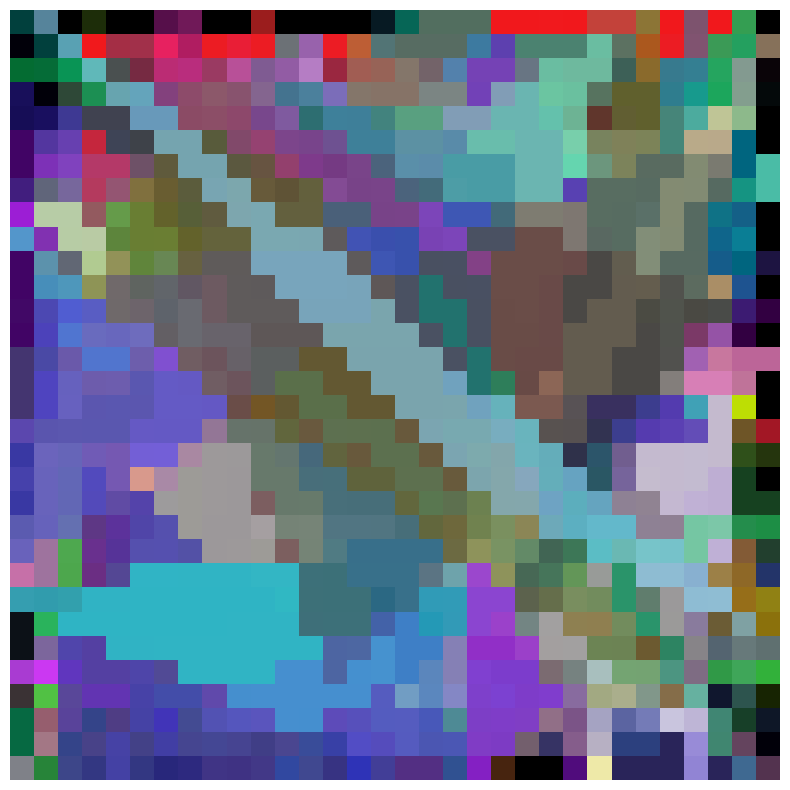

In [6]:
#@title Render an Individual
def extract_genes(genes, length):
    for i in range(0, len(genes), length):
        yield genes[i:i + length]

def render_individual(individual):
  if isinstance(individual,list):
    individual = np.array(individual)
  canvas = np.zeros(SIZE+(3,))
  radius_avg = (SIZE[0] + SIZE[1]) / 2 / 6
  genes = extract_genes(individual, GENE_LENGTH)
  for gene in genes:
    try:
      overlay = canvas.copy()
      # alternative drawing methods circle or rectangle
      # circle brush uses a GENE_LENGTH of 7
      # center = (0, 1) [2]
      # radius = (2) [3]
      # color = (3,4,5) [6]
      # alpha = (6) [7]
      #cv2.circle(
      #    overlay,
      #    center=(int(gene[1] * SIZE[1]), int(gene[0] * SIZE[0])),
      #    radius=int(gene[2] * radius_avg),
      #    color=color,
      #    thickness=-1,
      #)

      # rectangle brush uses GENE_LENGTH = 8
      # top left = (0, 1) [2]
      # btm right = (2, 3) [4]
      # color = (4, 5, 6) [7]
      # alpha = (7) [8]
      #cv2.rectangle(overlay, (x1, y1), (x2, y2), color, -1)

      # polyline brush uses GENE_LENGTH = 10
      # pts = (0, 1), (2, 3), (4, 5) [6]
      # color = (6, 7, 8) [9]
      # alpha = (9) [10]
      x1 = int(gene[0] * SIZE[0])
      x2 = int(gene[2] * SIZE[0])
      x3 = int(gene[4] * SIZE[0])
      y1 = int(gene[1] * SIZE[1])
      y2 = int(gene[3] * SIZE[1])
      y3 = int(gene[5] * SIZE[1])
      color = (gene[6:-1] * 255).astype(int).tolist()
      pts = np.array([[x1,y1],[x2,y2],[x3,y3]], np.int32)
      pts = pts.reshape((-1, 1, 2))
      pts = np.array([[x1,y1],[x2,y2],[x3,y3]])

      cv2.fillPoly(overlay, [pts], color)
      alpha = gene[-1]
      canvas = cv2.addWeighted(overlay, alpha, canvas, 1 - alpha, 0)
    except:
      pass
  return canvas

render = render_individual(individual)
show_image(render)

In [7]:
from skimage.metrics import structural_similarity as ss
#@title Fitness Function
def fitness_mse(render):
  """Calculates Mean Square Error Fitness for a render"""
  error = (np.square(render - target)).mean(axis=None)
  return error

def fitness_ss(render):
  """Calculated Structural Similiarity Fitness"""
  index = ss(render, target, multichannel=True)
  return 1-index

print(fitness_mse(render))

7475.44335588201


In [8]:
#@title ES Bounding Hyperparameters
IND_SIZE = NUM_GENES
MIN_VALUE = -1
MAX_VALUE = 1
MIN_STRATEGY = 0.5
MAX_STRATEGY = 5

CXPB = .6
MUTPB = .3

In [9]:
#@title Setting up the Creator
#creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
#creator.create("Individual", list, fitness=creator.FitnessMax)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, typecode="d", fitness=creator.FitnessMin, strategy=None)
creator.create("Strategy", list, typecode="d")

In [10]:
#@title Individual generator and decorate functions
def generateES(icls, scls, size, imin, imax, smin, smax):
  ind = icls(random.uniform(imin, imax) for _ in range(size))
  ind.strategy = scls(random.uniform(smin, smax) for _ in range(size))
  return ind

def checkStrategy(minstrategy):
  def decorator(func):
    def wrappper(*args, **kargs):
      children = func(*args, **kargs)
      for child in children:
        for i, s in enumerate(child.strategy):
          if s < minstrategy:
            child.strategy[i] = minstrategy
      return children
    return wrappper
  return decorator

In [11]:
def uniform(low, up, size=None):
  try:
    return [random.uniform(a, b) for a, b in zip(low, up)]
  except TypeError:
    return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

#toolbox = base.Toolbox()
#toolbox.register("attr_float", uniform, 0, 1, NUM_GENES)
#toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
#toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [12]:
def clamp(low, up, n):
  return max(low, min(n, up))

def custom_blend(ind1, ind2, alpha):
    for i, (x1, s1, x2, s2) in enumerate(zip(ind1, ind1.strategy,
                                             ind2, ind2.strategy)):
        # Blend the values
        gamma = (1. + 2. * alpha) * random.random() - alpha
        ind1[i] = clamp(0.0, 1.0, (1. - gamma) * x1 + gamma * x2)
        ind2[i] = clamp(0.0, 1.0, gamma * x1 + (1. - gamma) * x2)
        # Blend the strategies
        gamma = (1. + 2. * alpha) * random.random() - alpha
        ind1.strategy[i] = (1. - gamma) * s1 + gamma * s2
        ind2.strategy[i] = gamma * s1 + (1. - gamma) * s2


    return ind1, ind2

In [13]:
#@title Setup the Toolbox
toolbox = base.Toolbox()
toolbox.register("individual", generateES, creator.Individual, creator.Strategy,
    IND_SIZE, MIN_VALUE, MAX_VALUE, MIN_STRATEGY, MAX_STRATEGY)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", custom_blend, alpha=0.5)
toolbox.register("mutate", tools.mutESLogNormal, c=1.0, indpb=0.06)
toolbox.register("select", tools.selTournament, tournsize=5)

toolbox.decorate("mate", checkStrategy(MIN_STRATEGY))
toolbox.decorate("mutate", checkStrategy(MIN_STRATEGY))

In [14]:
def evaluate(individual):
  render = render_individual(individual)
  print('.', end='')
  return fitness_mse(render),  #using MSE for fitness

In [15]:
#@title Mutation and Evaluation
#toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=.1, indpb=.25)
toolbox.register("evaluate", evaluate)

In [16]:
random.seed(64)

NGEN = number_generations
RGEN = report_every_gen
CXPB = .6
MUTPB = .3
MU, LAMBDA = 100, 250
pop = toolbox.population(n=MU)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

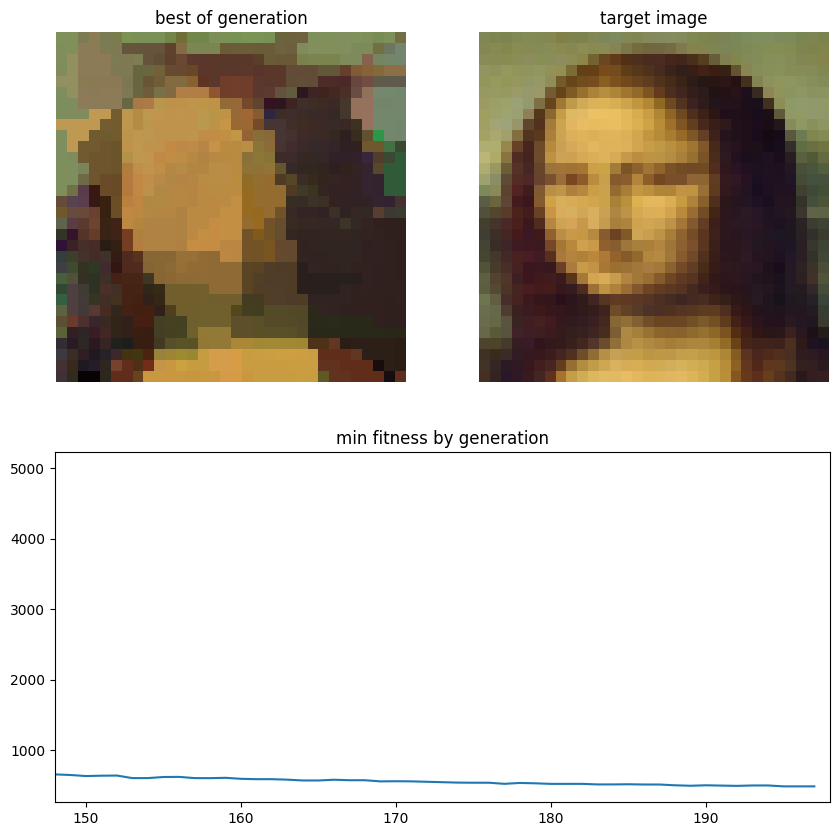

Gen (180) : best fitness = 485.9690168324407
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
best = None
history = []

for g in range(NGEN):
  pop, logbook = algorithms.eaMuCommaLambda(pop, toolbox, mu=MU, lambda_=LAMBDA,
            cxpb=CXPB, mutpb=MUTPB, ngen=RGEN, stats=stats, halloffame=hof, verbose=False)

  best = hof[0]
  #pop, logbook = algorithms.eaSimple(pop, toolbox,
  #         cxpb=CXPB, mutpb=MUTPB, ngen=100, stats=stats, halloffame=hof, verbose=False)
  #best = hof[0]
  clear_output()
  render = render_individual(best)
  history.extend([clamp(0.0, 5000.0, l["min"]) for l in logbook])
  show_results(history, render, target)
  print(f"Gen ({(g+1)*RGEN}) : best fitness = {fitness_mse(render)}")